In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('/kaggle/input/e-commerce-shoppers-behaviour-understanding/train_data_v2.csv')
test_data = pd.read_csv('/kaggle/input/e-commerce-shoppers-behaviour-understanding/test_data_v2.csv')

In [3]:
#Setting apart target variable i.e y.
y = data['Made_Purchase']
data.drop('Made_Purchase', axis=1, inplace=True)

In [4]:
data.columns

Index(['HomePage', 'HomePage_Duration', 'LandingPage', 'LandingPage_Duration',
       'ProductDescriptionPage', 'ProductDescriptionPage_Duration',
       'GoogleMetric:Bounce Rates', 'GoogleMetric:Exit Rates',
       'GoogleMetric:Page Values', 'SeasonalPurchase',
       'Month_SeasonalPurchase', 'OS', 'SearchEngine', 'Zone',
       'Type of Traffic', 'CustomerType', 'Gender', 'Cookies Setting',
       'Education', 'Marital Status', 'WeekendPurchase'],
      dtype='object')

In [5]:
data.drop(['OS', 'SearchEngine', 'Zone', 'Type of Traffic', 'Cookies Setting'], 
          axis=1, inplace=True)

In [6]:
#Spliting up numerical and categorical features of training_data.
categorical_features = data.loc[:,'Month_SeasonalPurchase':'WeekendPurchase']
numerical_features = data.drop(data.loc[:,'Month_SeasonalPurchase':'WeekendPurchase'], axis=1)

In [7]:
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
categoricalImputer = SimpleImputer(strategy='most_frequent')
numericalImputer = KNNImputer(weights='distance')

categorical_features = categoricalImputer.fit_transform(categorical_features)
numerical_features = numericalImputer.fit_transform(numerical_features)

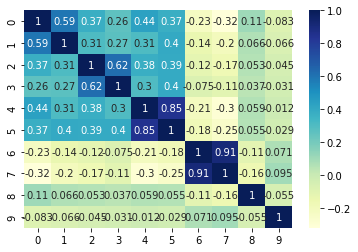

In [8]:
sns.heatmap(np.corrcoef(numerical_features.T), cmap="YlGnBu", annot=True)
sns.set(rc={"figure.figsize":(11, 11)})
plt.show;

In [9]:
numerical_features = np.delete(numerical_features, [4, 7], 1)

In [10]:
from sklearn.preprocessing import OneHotEncoder
oneHot = OneHotEncoder(sparse=False, drop='first')
categorical_array = oneHot.fit_transform(categorical_features)

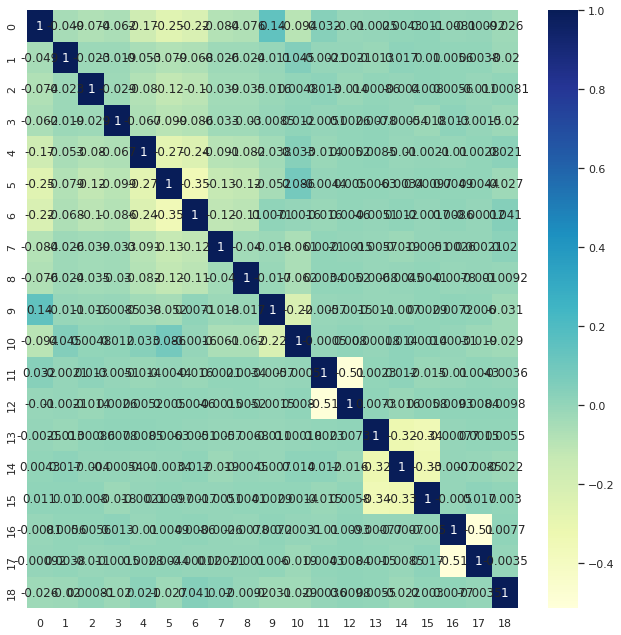

In [11]:
sns.heatmap(np.corrcoef(categorical_array.T), cmap="YlGnBu", annot=True)
sns.set(rc={"figure.figsize":(25, 20)})
plt.show;

In [12]:
categorical_array = np.delete(categorical_array, 12, 1)

In [13]:
from sklearn.preprocessing import FunctionTransformer
scaler = FunctionTransformer(np.log1p)
numerical_array = scaler.fit_transform(numerical_features)

In [14]:
X = np.column_stack((numerical_array, categorical_array))

In [15]:
test_data.drop(['OS', 'SearchEngine', 'Zone', 'Type of Traffic', 'Cookies Setting'],
               axis=1, inplace=True)

In [16]:
#Spliting up numerical and categorical features in test_data.
categorical_features_T = test_data.loc[:,'Month_SeasonalPurchase':'WeekendPurchase']
numerical_features_T = test_data.drop(data.loc[:,'Month_SeasonalPurchase':'WeekendPurchase'], axis=1)

In [17]:
categorical_features_T = categoricalImputer.transform(categorical_features_T)
numerical_features_T = numericalImputer.transform(numerical_features_T)

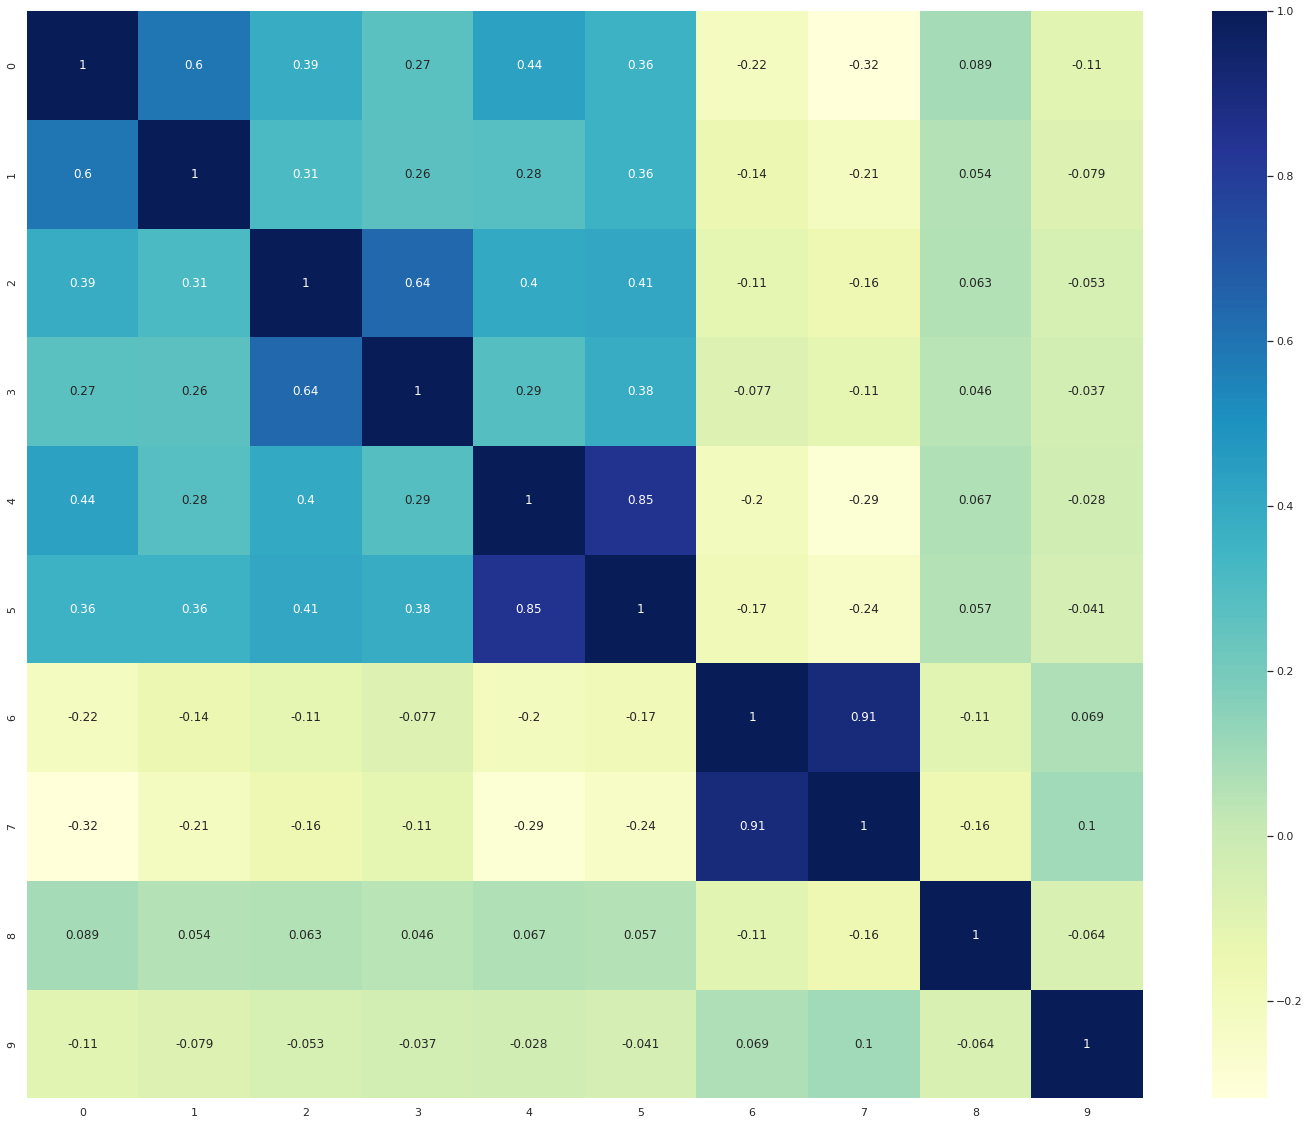

In [18]:
sns.heatmap(np.corrcoef(numerical_features_T.T), cmap="YlGnBu", annot=True)
sns.set(rc={"figure.figsize":(11, 11)})
plt.show;

In [19]:
numerical_features_T = np.delete(numerical_features_T, [4, 7], 1)

In [20]:
categorical_array_T = oneHot.transform(categorical_features_T)
numerical_array_T = scaler.transform(numerical_features_T)

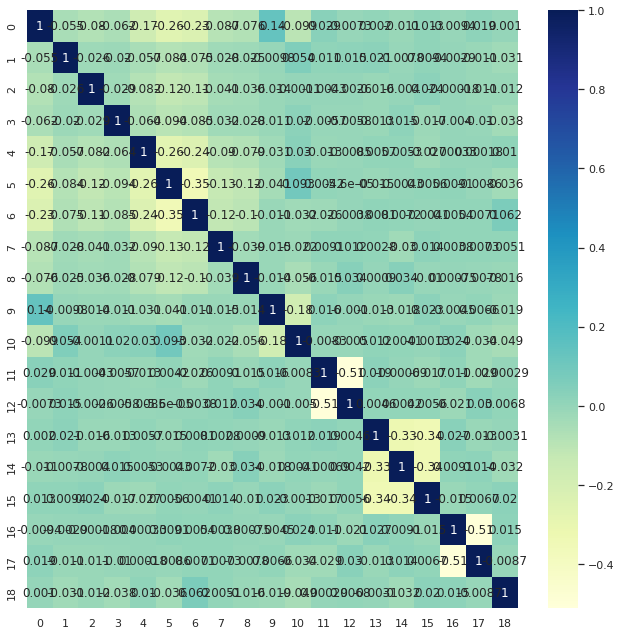

In [21]:
sns.heatmap(np.corrcoef(categorical_array_T.T), cmap="YlGnBu", annot=True)
sns.set(rc={"figure.figsize":(25, 20)})
plt.show;

In [22]:
categorical_array_T = np.delete(categorical_array_T, 12, 1)

In [23]:
X_test = np.column_stack((numerical_array_T, categorical_array_T))

In [24]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

gradBoost = GradientBoostingClassifier(subsample=0.6, n_estimators=300, learning_rate=0.01, random_state=11)
logisticRegression = LogisticRegression(C=0.25, max_iter=150, solver='sag', random_state=11)
adaBoost = AdaBoostClassifier(n_estimators=300, learning_rate=0.001, random_state=11)
randomForest = RandomForestClassifier(min_samples_split=300, n_estimators=375, random_state=11)
votingClassifier = VotingClassifier(estimators=[('randomForest', randomForest), ('adaBoost', adaBoost), ('gradBoost', gradBoost),
                                               ('logisticRegression', logisticRegression)], voting='soft')

votingClassifier.fit(X, y)

VotingClassifier(estimators=[('randomForest',
                              RandomForestClassifier(min_samples_split=300,
                                                     n_estimators=375,
                                                     random_state=11)),
                             ('adaBoost',
                              AdaBoostClassifier(learning_rate=0.001,
                                                 n_estimators=300,
                                                 random_state=11)),
                             ('gradBoost',
                              GradientBoostingClassifier(learning_rate=0.01,
                                                         n_estimators=300,
                                                         random_state=11,
                                                         subsample=0.6)),
                             ('logisticRegression',
                              LogisticRegression(C=0.25, max_iter=150,
                      

In [25]:
from sklearn.metrics import f1_score
f1_score(y, votingClassifier.predict(X), average='micro')

0.6722557871156065

In [26]:
prediction = votingClassifier.predict(X_test)
submission = pd.DataFrame(columns=['id', 'Made_Purchase'])
submission['id'] = [i for i in range(len(prediction))]
submission["Made_Purchase"] = prediction
submission.to_csv('submission.csv',index=False)